<a href="https://colab.research.google.com/github/Kushanyasiru97/Research_Algorithms/blob/main/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU device found')
    print('Name:', tf.test.gpu_device_name())
else:
    print("No GPU device found. Make sure you have selected a GPU runtime in Colab.")


GPU device found
Name: /device:GPU:0


In [77]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8ba09578-6869-0de0-cb40-5ef12fd7388a)


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 39.5 ms, sys: 7.58 ms, total: 47.1 ms
Wall time: 6.23 s


In [80]:
import ultralytics
print(ultralytics.__version__)

8.1.6


In [81]:
! wandb disabled

/bin/bash: line 1: wandb: command not found


In [82]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [83]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Biological', 'Metal', 'Paper', 'Plastic']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

        # training
    EPOCHS = 3 if DEBUG else 50 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto

    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

     # paths
    CUSTOM_DATASET_DIR = '/content/drive/MyDrive/WasteData/'
    OUTPUT_DIR = './'

In [84]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'validation'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [85]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Biological
- Metal
- Paper
- Plastic
nc: 4
test: /content/drive/MyDrive/WasteData/test
train: /content/drive/MyDrive/WasteData/train
val: /content/drive/MyDrive/WasteData/validation



In [86]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (268, 188, 3) 



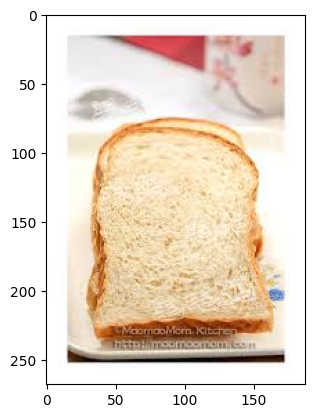

In [87]:
example_image_path = '/content/drive/MyDrive/WasteData/train/images/biological2.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [88]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

      # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

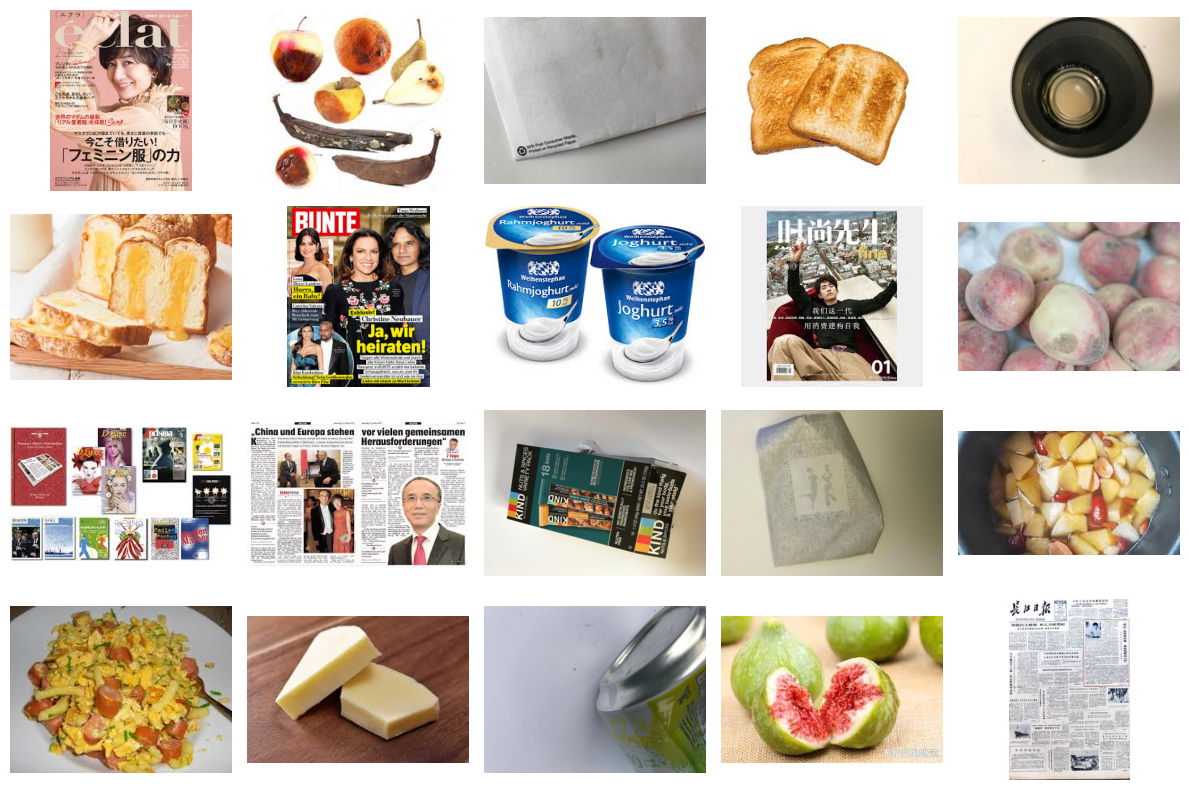

In [89]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

In [90]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [91]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 188, 'height': 268, 'channels': 3, 'dtype': dtype('uint8')}

In [93]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'validation', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 127 ms, sys: 76.3 ms, total: 204 ms
Wall time: 2.83 s


,Mode,Biological,Metal,Paper,Plastic,Data_Volume
0,train,297,206,237,111,849
1,validation,0,0,0,5,5
2,test,7,0,0,0,7


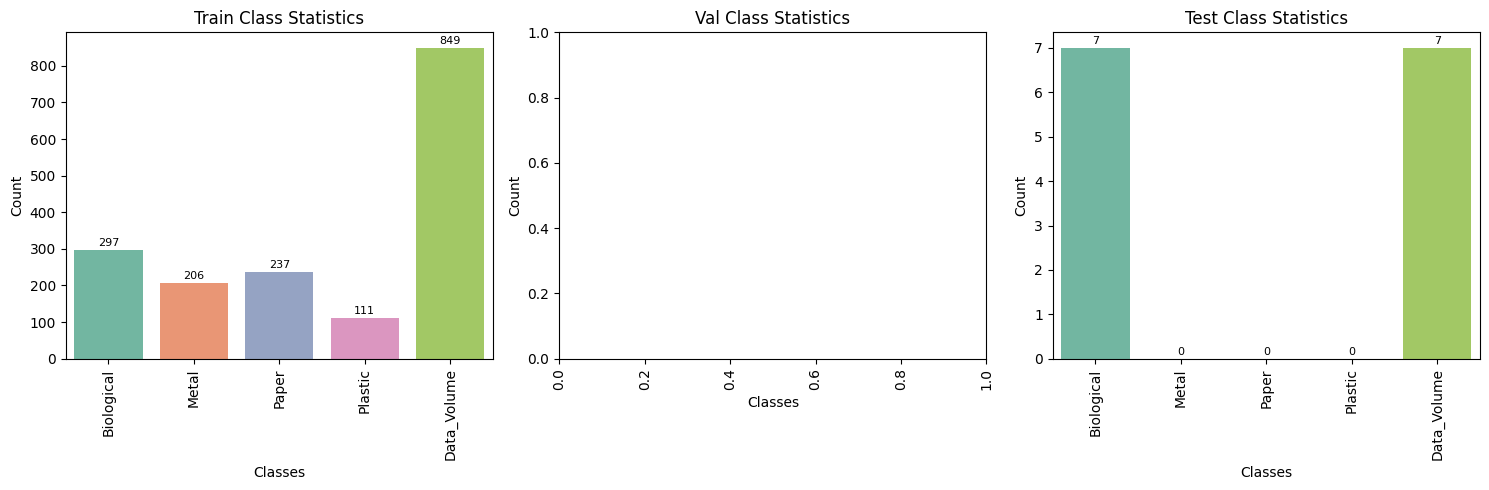

In [94]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'val', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')
plt.tight_layout()
plt.show()

In [95]:
%%time

for mode in ['train', 'val', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(169, 299)


(310, 162)


(248, 204)


(251, 200)


(264, 191)


(269, 187)


(275, 183)


(246, 205)


(274, 184)


(259, 194)


(289, 174)


(276, 183)


(262, 193)


(168, 299)


(259, 194)


(275, 183)


(278, 181)


(300, 168)


(221, 228)


(259, 194)


(266, 189)


(279, 181)


(280, 180)


(279, 181)


(285, 177)


(259, 194)


(228, 221)


(269, 187)


(188, 268)


(275, 183)


(289, 174)


(285, 177)


(275, 183)


(156, 324)


(263, 192)


(318, 159)


(292, 172)


(259, 194)


(271, 186)


(200, 252)


(225, 225)


(259, 194)


(268, 188)


(197, 256)


(283, 178)


(183, 275)


(284, 177)


(280, 180)


(267, 189)


(275, 183)


(194, 259)


(270, 187)


(275, 183)


(268, 188)


(194, 259)


(275, 183)


(300, 168)


(288, 175)


(194, 259)


(275, 183)


(194, 260)


(279, 181)


(183, 275)


(259, 194)


(266, 189)


(338, 149)


(194, 259)


(259, 194)


(250, 202)


(274, 184)


(275, 183)


(232, 217)


(299, 168)


(288, 175)


(337, 150)


In [96]:
CFG.BASE_MODEL_WEIGHTS

'yolov8x.pt'

In [97]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = [0], # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


WARNING ⚠️ imgsz=[268, 188] must be multiple of max stride 32, updating to [288, 192]
image 1/1 /content/drive/MyDrive/WasteData/train/images/biological2.jpg: 288x192 (no detections), 27.1ms
Speed: 0.9ms preprocess, 27.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 192)
Results saved to runs/detect/predict
0 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (268, 188, 3) 



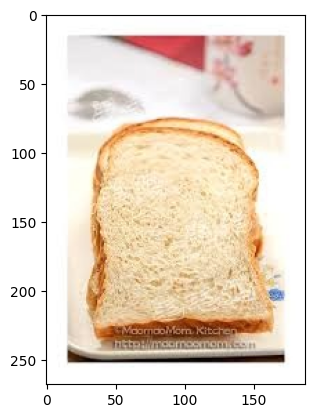

In [98]:
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/{example_image_inference_output}')

In [99]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  50
Batch:  16


In [100]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [101]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR,'./data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
)


Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=././data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(268, 188), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 6.23M/6.23M [00:00<00:00, 130MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=268'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
WARNING ⚠️ imgsz=[268] must be multiple of max stride 32, updating to [288]


train: Scanning /content/drive/MyDrive/WasteData/train/labels... 849 images, 29 backgrounds, 5 corrupt: 100%|██████████| 878/878 [00:06<00:00, 135.16it/s]

train: WARNING ⚠️ /content/drive/MyDrive/WasteData/train/images/biological259.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 4. Possible class labels are 0-3
train: WARNING ⚠️ /content/drive/MyDrive/WasteData/train/images/biological262.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 4. Possible class labels are 0-3
train: WARNING ⚠️ /content/drive/MyDrive/WasteData/train/images/met (195).jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 4. Possible class labels are 0-3
train: WARNING ⚠️ /content/drive/MyDrive/WasteData/train/images/met (33).jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 4. Possible class labels are 0-3
train: WARNING ⚠️ /content/drive/MyDrive/WasteData/train/images/plastic81.jpg: ignoring corrupt image/label: Label class 17 exceeds dataset class count 4. Possible class labels are 0-3


train: New cache created: /content/drive/MyDrive/WasteData/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/WasteData/validation/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 83.54it/s]

val: New cache created: /content/drive/MyDrive/WasteData/validation/labels.cache


Plotting labels to runs/detect/yolov8x_ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 288 train, 288 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8x_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.78G      1.016       1.81      1.357         34        288: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all          5         12     0.0178        0.5     0.0336    0.00592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.88G      1.243      1.773      1.509         36        288: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


                   all          5         12      0.384      0.333      0.199     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.75G      1.325      1.846      1.591         29        288: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]

                   all          5         12      0.125     0.0833      0.029     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.87G      1.317      1.752      1.602         36        288: 100%|██████████| 55/55 [00:18<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]

                   all          5         12     0.0308      0.333     0.0311    0.00681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.87G      1.265      1.705      1.558         44        288: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all          5         12      0.535      0.333      0.291      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.76G      1.258      1.651      1.529         48        288: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

                   all          5         12       0.47      0.333      0.311      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.77G      1.169      1.552      1.475         33        288: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all          5         12      0.497      0.167      0.185     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.88G      1.161      1.556      1.493         56        288: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all          5         12      0.933      0.333      0.363      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.89G      1.119      1.465       1.45         37        288: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]

                   all          5         12      0.308      0.333      0.288      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.88G      1.114      1.444      1.455         46        288: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]

                   all          5         12      0.479      0.167      0.258      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.76G      1.084      1.371       1.41         44        288: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all          5         12      0.455      0.333      0.373      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       4.9G      1.045      1.359      1.423         22        288: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all          5         12      0.589       0.25      0.315       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.76G      1.036      1.331      1.393         31        288: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]

                   all          5         12      0.262       0.25       0.33      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.89G      1.027      1.354       1.39         20        288: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all          5         12      0.585      0.333      0.532      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.75G      1.025      1.289      1.374         52        288: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

                   all          5         12      0.767      0.333      0.542      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.77G     0.9826       1.24      1.364         33        288: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          5         12      0.606      0.387      0.441      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       4.9G     0.9657      1.207      1.344         45        288: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          5         12      0.754      0.333      0.611      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.89G     0.9744      1.222      1.355         32        288: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]

                   all          5         12      0.826      0.398      0.484      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.89G     0.9602      1.156      1.336         45        288: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]

                   all          5         12      0.672      0.855      0.791      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.89G     0.9462      1.109      1.331         40        288: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]

                   all          5         12      0.807      0.583      0.777      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.77G     0.9244      1.139      1.312         35        288: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]

                   all          5         12      0.795      0.648       0.87      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.89G     0.9504      1.145      1.333         33        288: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all          5         12      0.834      0.838      0.902      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.75G     0.9188      1.042      1.298         34        288: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all          5         12      0.544      0.597      0.685      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.88G     0.9345       1.09      1.319         32        288: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]

                   all          5         12      0.986      0.583      0.807      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.89G     0.9104      1.067      1.318         40        288: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

                   all          5         12      0.879       0.75      0.887      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.76G      0.879      1.056      1.297         32        288: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all          5         12      0.904      0.917      0.955       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.76G     0.8913      1.012      1.304         33        288: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

                   all          5         12      0.767      0.667      0.798       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.89G     0.8762      1.006      1.292         43        288: 100%|██████████| 55/55 [00:17<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all          5         12      0.804       0.75      0.839      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       4.9G     0.8714     0.9849      1.309         30        288: 100%|██████████| 55/55 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all          5         12      0.814      0.731       0.84      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.76G     0.9051     0.9866      1.305         20        288: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

                   all          5         12      0.797      0.833      0.879      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.89G     0.8474     0.9482      1.265         39        288: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

                   all          5         12      0.885      0.833      0.897      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.88G     0.8188     0.8821      1.248         40        288: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all          5         12      0.839      0.871        0.9      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.76G     0.8372     0.8894       1.25         41        288: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]

                   all          5         12      0.813      0.833      0.851       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.89G     0.8243     0.8877      1.252         46        288: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

                   all          5         12      0.977      0.833      0.931      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.89G     0.8318     0.8933      1.258         44        288: 100%|██████████| 55/55 [00:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all          5         12          1      0.808      0.908      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       4.9G     0.8037     0.8503      1.242         24        288: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]

                   all          5         12      0.926       0.75      0.883      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.89G     0.8061     0.8499      1.248         39        288: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]

                   all          5         12      0.906      0.833      0.933      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.89G     0.8132     0.8282      1.236         36        288: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all          5         12       0.99       0.75      0.939      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       4.9G     0.7812     0.8032      1.219         35        288: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]

                   all          5         12      0.898      0.917      0.957      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.88G     0.7888     0.7841      1.229         54        288: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]

                   all          5         12          1      0.957      0.995      0.816


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.89G     0.7584     0.7819      1.213         12        288: 100%|██████████| 55/55 [00:20<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all          5         12      0.877      0.917      0.954      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       4.9G     0.7205     0.7122      1.186         18        288: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]

                   all          5         12      0.883      0.833      0.946      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.75G     0.7201     0.7003      1.209         18        288: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]

                   all          5         12      0.854       0.98      0.964      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.76G     0.7136     0.6837      1.197         14        288: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all          5         12      0.992      0.917      0.968        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.89G      0.706     0.6669      1.184         10        288: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


                   all          5         12      0.992      0.917      0.971      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.76G      0.673     0.6276      1.151         27        288: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]

                   all          5         12      0.991      0.917      0.979      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.76G      0.651     0.6446      1.151          9        288: 100%|██████████| 55/55 [00:18<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all          5         12      0.998      0.917      0.979      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.76G     0.6575     0.5816      1.148         21        288: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]

                   all          5         12      0.996      0.917      0.989      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.76G     0.6387     0.5645      1.134         14        288: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]

                   all          5         12          1      0.981      0.995      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       4.9G     0.6337     0.5395      1.133         20        288: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all          5         12          1      0.912      0.984      0.807



50 epochs completed in 0.341 hours.
Optimizer stripped from runs/detect/yolov8x_ppe_css_50_epochs/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/yolov8x_ppe_css_50_epochs/weights/best.pt, 136.7MB

Validating runs/detect/yolov8x_ppe_css_50_epochs/weights/best.pt...
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


                   all          5         12          1      0.957      0.995      0.816
Speed: 0.1ms preprocess, 9.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/yolov8x_ppe_css_50_epochs
CPU times: user 13min 30s, sys: 1min 49s, total: 15min 19s
Wall time: 20min 58s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9140b8aad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [102]:
img_properties

{'width': 188, 'height': 268, 'channels': 3, 'dtype': dtype('uint8')}

In [103]:
# Export the model
model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
WARNING ⚠️ imgsz=[268, 188] must be multiple of max stride 32, updating to [288, 192]
Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'runs/detect/yolov8x_ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 288, 192) BCHW and output shape(s) (1, 8, 1134) (130.3 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 69.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.3s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 28.8s, saved as 'runs/detect/yolov8x_ppe_css_50_epochs/weights/best.onnx' (260.0 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpd

'runs/detect/yolov8x_ppe_css_50_epochs/weights/best_openvino_model'

In [104]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/R_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/P_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/results.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/PR_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/F1_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/labels.jpg',
 './runs/detect/yolov8x_ppe_css_50_epochs/labels_correlogram.jpg']

./runs/detect/yolov8x_ppe_css_50_epochs/F1_curve.png


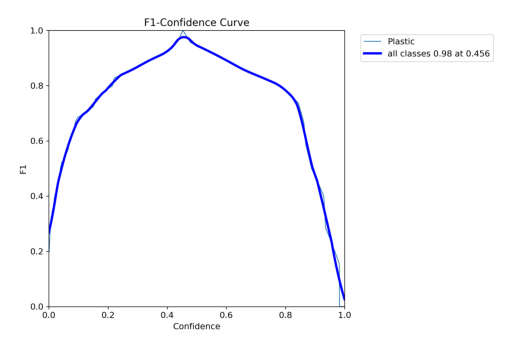



./runs/detect/yolov8x_ppe_css_50_epochs/PR_curve.png


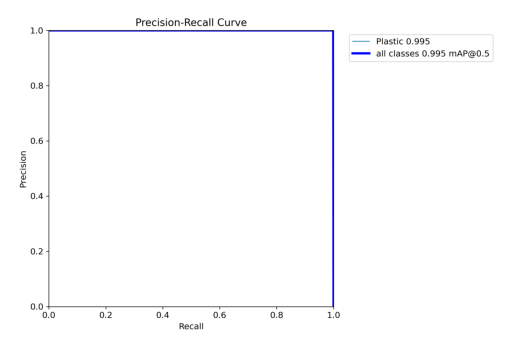



./runs/detect/yolov8x_ppe_css_50_epochs/P_curve.png


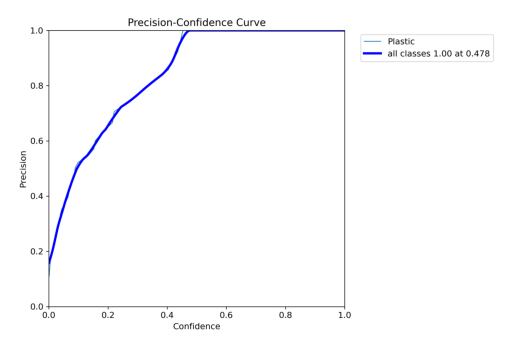



./runs/detect/yolov8x_ppe_css_50_epochs/R_curve.png


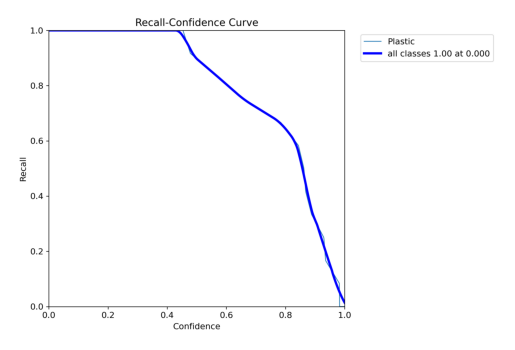



./runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix.png


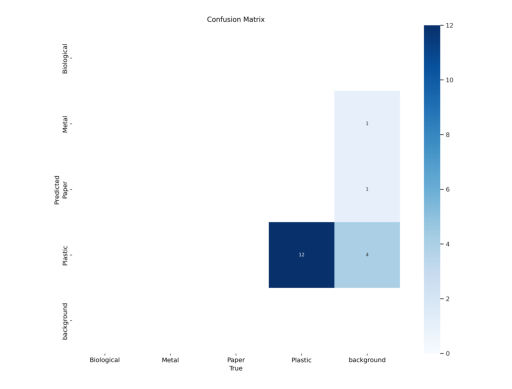



./runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix_normalized.png


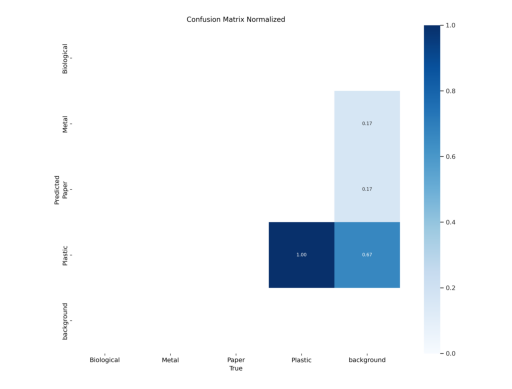



./runs/detect/yolov8x_ppe_css_50_epochs/labels.jpg


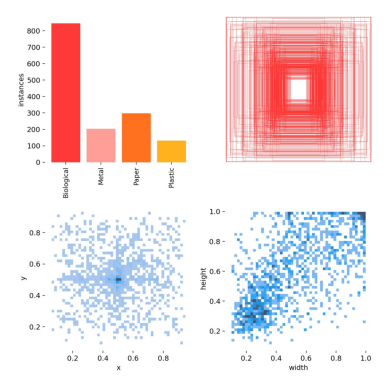



./runs/detect/yolov8x_ppe_css_50_epochs/labels_correlogram.jpg


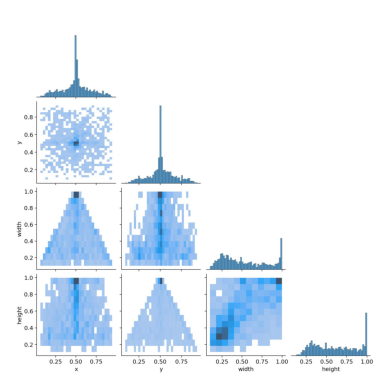



./runs/detect/yolov8x_ppe_css_50_epochs/results.png


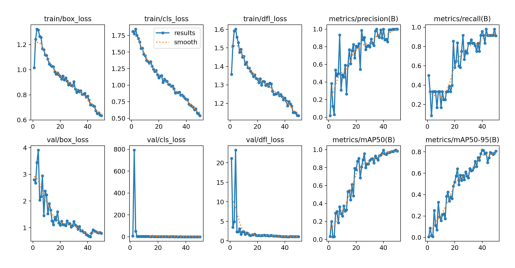

In [105]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [106]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.01570,1.81040,1.3571,0.01779,0.50000,0.03357,0.00592,2.79180,inf,21.1370,0.000409,0.000409,0.000409
1,2,1.24280,1.77320,1.5093,0.38384,0.33333,0.19875,0.08759,2.67120,7.6699,3.4666,0.000809,0.000809,0.000809
2,3,1.32470,1.84590,1.5913,0.12506,0.08333,0.02899,0.01739,3.43760,791.65,4.8972,0.001193,0.001193,0.001193
3,4,1.31740,1.75220,1.6021,0.03077,0.33333,0.03114,0.00681,3.90640,51.611,23.2520,0.001176,0.001176,0.001176
4,5,1.26540,1.70500,1.5577,0.53508,0.33333,0.29148,0.25110,2.03740,4.479,2.3123,0.001176,0.001176,0.001176
5,6,1.25840,1.65110,1.5287,0.46989,0.33333,0.31067,0.11165,2.16970,3.5148,2.2793,0.001151,0.001151,0.001151
6,7,1.16880,1.55220,1.4753,0.49678,0.16667,0.18548,0.06973,2.94450,4.2661,3.0758,0.001126,0.001126,0.001126
7,8,1.16050,1.55570,1.4927,0.93337,0.33333,0.36264,0.32884,1.45340,3.316,1.6610,0.001102,0.001102,0.001102
8,9,1.11880,1.46510,1.4499,0.30788,0.33333,0.28778,0.19339,2.37240,3.3591,2.2826,0.001077,0.001077,0.001077
9,10,1.11430,1.44370,1.4547,0.47934,0.16667,0.25842,0.15656,2.22490,3.2073,2.3308,0.001052,0.001052,0.001052


In [107]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.63367 , on epoch:  50 


Best Validation Box loss:  0.6606 , on epoch:  42 


Best Training Cls loss:  0.53948 , on epoch:  50 


Best Validation Cls loss:                      inf , on epoch:  42 


Best Training DFL loss:  1.1331 , on epoch:  50 


Best Validation DFL loss:  1.0424 , on epoch:  42 



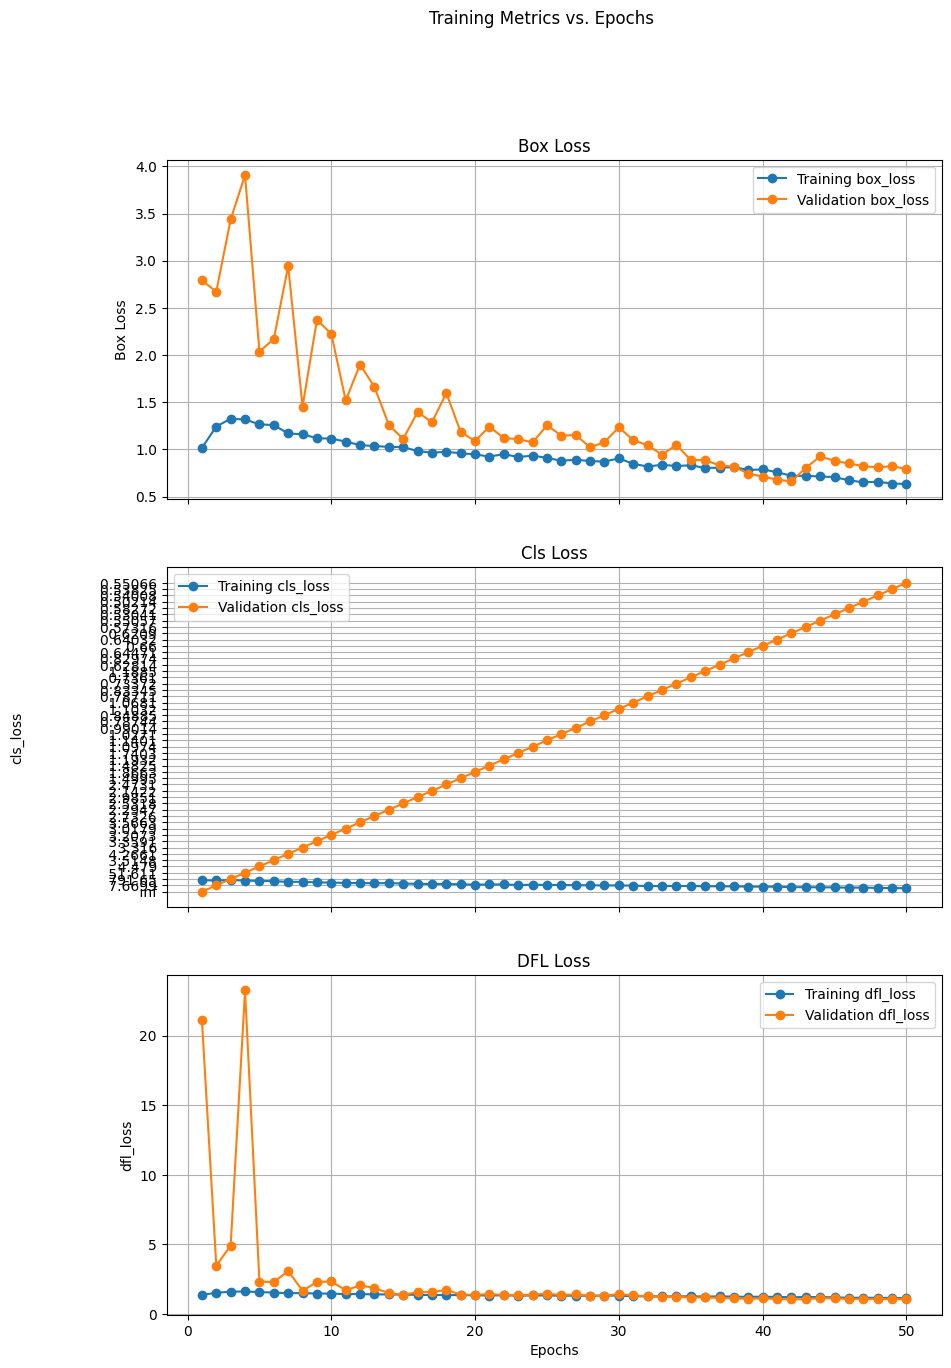

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation Box Loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [109]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

2

In [110]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8x_ppe_css_50_epochs/val_batch0_labels.jpg


./runs/detect/yolov8x_ppe_css_50_epochs/val_batch0_labels.jpg


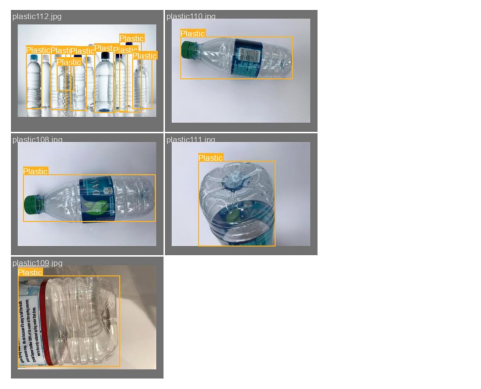

In [111]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)